#### Read data

In [83]:
import os
import numpy as np
import pickle
import random

def read_data(file):
    '''
    Read each file into a list of strings. 
    Example:
    ["it's", 'a', 'curious', 'thing', "i've", 'found', 'that', 'when', 'willis', 'is', 'not', 'called', 'on', 
    ...'to', 'carry', 'the', 'whole', 'movie', "he's", 'much', 'better', 'and', 'so', 'is', 'the', 'movie']
    '''
    f = open(file)
    lines = f.read().split(' ')
    symbols = '${}()[].,:;+-*/&|<>=~" '
    words = map(lambda Element: Element.translate(str.maketrans("", "", symbols)).strip(), lines)
    words = filter(None, words)
    return list(words)


In [84]:
def folder_list(path,label):
    '''
    PARAMETER PATH IS THE PATH OF YOUR LOCAL FOLDER
    '''
    filelist = os.listdir(path)
    review = []
    for infile in filelist:
        file = os.path.join(path,infile)
        r = read_data(file)
        r.append(label)
        review.append(r)
    return review


In [85]:
def shuffle_data():
    '''
    pos_path is where you save positive review data.
    neg_path is where you save negative review data.
    '''
    pos_path = "data/pos"
    neg_path = "data/neg"
    
    pos_review = folder_list(pos_path,1)
    neg_review = folder_list(neg_path,-1)
    review = pos_review + neg_review
    random.shuffle(review)
    return list(review)

### Split and save by pickle

In [86]:
def split_and_save(pickle_fname = "data/shuffled_review.pickle", test_frac = .25):
    '''
    pickle_fname - pickle file name for saveing data
    test_frac - spliting fraction 
    '''
    review = shuffle_data()
    n_test = int(len(review) * test_frac)
    
    test = review[:n_test]
    train = review[n_test:]
    
    data = {"train":train, "test":test}
    
    pickle_out = open (pickle_fname, "wb")
    pickle.dump(data, pickle_out)
    pickle_out.close()

split_and_save()

### Load from pickle

In [87]:
def load_from_pickle(pickle_fname = "data/shuffled_review.pickle"):
    file = open(pickle_fname, 'rb')
    data = pickle.load(file)
    file.close()
    return data["train"], data["test"]

### Util functions

In [155]:
def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())

def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.

    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale
        
def scalarMult(scale, d):
    for f, v in d.items():
        d[f] = scale * d[f]

def scalarMult1(scale, d):
    r = dict()
    for f, v in d.items():
        r[f] = scale * d[f]
    return r

In [89]:
def _bagOfWords(words):
    from collections import Counter
    dw = Counter()
    dw.update(words)
    return dw.most_common()
    
    

### Load train and test data

In [90]:
train, test = load_from_pickle()

### Convert to bag of words

In [91]:
#Black_list
black_list = ['i', 'if', 'a', 'so', 'you', 'an','and', 'the', 'to', 'of', 'on', 'with', 'in', 'as', 'is', 'at', 'up', 'be', 'by', 'this', 'are', 'even', 'from', 'it', 'was', 'all', 'for']
def bagOfWords(data):
    """
    Input : ["a", "b", "c", "a", "b", "b", "c", "d"]
    Output : {"a":2, "b":3, "c":2, "d":1}
    """
    output = []
    labels = []
    for d in data:
        di = dict(_bagOfWords(d))
        for j in black_list:
            if j in di:
                del di[j]
        #filter
        if 1 in di:
            labels.append(1)
            del di[1]
        else:
            assert -1 in di
            labels.append(-1)
            del di[-1]
        output.append(di)
    return output, labels

In [92]:
train_data, train_labels = bagOfWords(train)


### The Pegasos Algorithm 

\begin{align}
OBJECTIVE - f(w) = \lambda / 2  \lVert w \rVert ^ 2 + 1/m  \sum_{i=1}^n l(w;(x, y)) \\
Hinge\ loss - l(w;(x, y)) = max (0, 1 - y w^Tx) \\
\end{align}
$
\begin{align}
INPUT: S, λ, T \\
INITIALIZE: Set \ w_1 & = 0 \\
FOR\ t = 1, 2, . . . , T \\
&Choose\ i_t ∈ {1, . . . , |S|}\ uniformly\ at\ random \\
&η_t = 1 / λt \\
&IF y_{i_t}w_t^Tx_{i_t} < 1\\
&\ \ \ w_{t + 1} = (1 - η_t λ)w_t + η_t y_{i_t} x_{i_t} \\
&ELSE \\
&\ \ \ w_{t + 1} = (1 - η_t λ)w_t \\
OUTPUT: w_{T+1} \\
\end{align}
$

In [93]:
def pegasos(train, labels, niters, Lambda):
    n = len(train)
    w = dict()
    for i in range(niters):
        
        j = np.random.randint(0, n)
                
        eta = 1.0 / (Lambda * (i + 1))
            
        if labels[j] * dotProduct(w, train[j]) < 1:
            scalarMult((1 - 1.0/(i + 1)), w)
            increment(w, labels[j] * eta, train[j])
        else:
            scalarMult((1 - 1.0/(i + 1)), w)
    return w


### The Pegasos Algorithm  (optimized)

$
\begin{align}
&\ \ \ w_{t + 1} = 1/λt \sum_{i=1}^n V^i\ \ \ where\ V^i\ is\ Subgradient\ of\ Hinge\ loss\\
\end{align}
$

In [163]:
def pegasos1(train, labels, niters, Lambda):
    n = len(train)
    w = dict()
    theta = dict()
    
    for i in range(niters):
        j = np.random.randint(0, n)
        
        if labels[j] * dotProduct(w, train[j]) < 1:
            increment(theta, -labels[j], train[j])
        w = scalarMult1((-1.0/(Lambda * (i + 1))), theta)

    return scalarMult1(-1.0/(Lambda * niters), theta)

In [169]:
test_data, test_labels = bagOfWords(test)

ll = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
min_failed = len(test_labels)
max_success = 0
Lambda = 0
for l in ll:
    w = pegasos1(train_data, train_labels, 500, l)
    failed = 0
    success = 0
    for i in range(len(test_labels)):
        score = test_labels[i] * dotProduct(test_data[i], w)
        if score < 1:
            failed = failed + 1
        else:
            success = success + 1
    if min_failed > failed:
        min_failed = failed
        max_success = success
        Lambda = l
    
print (min_failed)
print (max_success)
print (Lambda)

124
376
1e-08


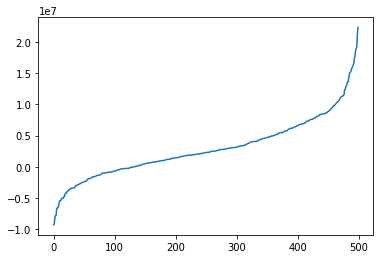

In [165]:
w = pegasos1(train_data, train_labels, 1000, 1e-07)
scores = []
fails = []
for i in range(len(test_labels)):
    score = test_labels[i] * dotProduct(test_data[i], w)
    scores.append(score)
    if score < 1:
        f = test_data[i]
        f[test_labels[i]] = 1
        fails.append(f)

scores.sort()
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(scores)
plt.show()

In [166]:
def ErrorAnalysis(fails, w):
    ll = []
    for fail in fails:
        l = []
        for f, v in fail.items():
            if f in w:
                l.append((abs(v * w.get(f)), f, v, w.get(f), w.get(1, -1)))
        l = sorted(l, key=lambda x: (x[0]), reverse=True)
        ll.append(l)
    return ll
ll = ErrorAnalysis(fails, w)

In [167]:
for i in range(1, len(ll)):
    for j in range(25):
        print (ll[i][j])
    print ('\n')

(2380000.0, 'film', 14, -170000.0, -1)
(1980000.0, "it's", 9, 220000.0, -1)
(1170000.0, 'out', 9, -130000.0, -1)
(1140000.0, 'that', 19, 60000.0, -1)
(1120000.0, 'his', 7, 160000.0, -1)
(1100000.0, 'bad', 2, -550000.0, -1)
(1000000.0, 'one', 4, 250000.0, -1)
(930000.0, 'very', 3, 310000.0, -1)
(870000.0, 'most', 3, 290000.0, -1)
(840000.0, 'hit', 7, 120000.0, -1)
(800000.0, 'they', 8, -100000.0, -1)
(720000.0, 'has', 8, 90000.0, -1)
(700000.0, 'but', 7, 100000.0, -1)
(690000.0, 'same', 3, 230000.0, -1)
(690000.0, 'good', 3, 230000.0, -1)
(650000.0, 'who', 5, -130000.0, -1)
(580000.0, 'then', 2, -290000.0, -1)
(570000.0, 'never', 3, -190000.0, -1)
(570000.0, 'way', 3, 190000.0, -1)
(540000.0, 'do', 3, -180000.0, -1)
(540000.0, 'have', 2, -270000.0, -1)
(520000.0, 'work', 4, -130000.0, -1)
(510000.0, 'go', 3, 170000.0, -1)
(420000.0, 'fun', 3, 140000.0, -1)
(400000.0, 'also', 2, 200000.0, -1)


(1620000.0, 'have', 6, -270000.0, -1)
(1470000.0, 'about', 3, -490000.0, -1)
(1320000.0, 'will

(340000.0, 'film', 2, -170000.0, -1)
(330000.0, 'will', 1, 330000.0, -1)
(320000.0, 'some', 2, -160000.0, -1)
(300000.0, 'effects', 2, -150000.0, -1)
(290000.0, 'director', 1, -290000.0, -1)
(290000.0, 'then', 1, -290000.0, -1)
(260000.0, 'past', 2, 130000.0, -1)
(210000.0, 'godzilla', 1, -210000.0, -1)
(210000.0, 'few', 1, 210000.0, -1)
(200000.0, 'better', 2, -100000.0, -1)
(190000.0, 'way', 1, 190000.0, -1)
(180000.0, 'has', 2, 90000.0, -1)
(180000.0, 'special', 2, -90000.0, -1)
(180000.0, 'do', 1, -180000.0, -1)
(180000.0, 'enough', 1, -180000.0, -1)
(170000.0, 'guess', 1, -170000.0, -1)


(2500000.0, 'one', 10, 250000.0, -1)
(1980000.0, 'will', 6, 330000.0, -1)
(1700000.0, 'film', 10, -170000.0, -1)
(1240000.0, 'very', 4, 310000.0, -1)
(1080000.0, 'that', 18, 60000.0, -1)
(1080000.0, 'any', 3, -360000.0, -1)
(1040000.0, 'out', 8, -130000.0, -1)
(950000.0, 'never', 5, -190000.0, -1)
(850000.0, 'can', 5, 170000.0, -1)
(800000.0, 'school', 8, -100000.0, -1)
(750000.0, 'she', 15, 5000